In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

# Датасет:

В датасете представлены продажи спортивной обуви в период 2018-2019 гг в собственной розничной сети:
* Article/Placeholder NO - товарная позиция (SKU)
* Sales Line/Subtheme Manual - название категории товара
* RRP, RUB - реккомендованная розничная цена
* IBP NoS - кол-во розничных магазинов, где продавалась SKU
* IBP LC - кол-во недель продаж для SKU
* IBP QTY - фактический объем продаж в штуках - это наша целевая переменная

Итак, цель построить модель регрессии объма продаж от цены, кол-ма магазинов и кол-ва продаж.
Так же будет интересно посмотреть зависимоть категории товара от объема продаж (дисперсионный анализ)

In [98]:
df = pd.read_csv('/Users/antosale/Desktop/Geek Brains/exam_dataset')
df.head()

,Unnamed: 0,Article/Placeholder NO,Sales Line/Subtheme Manual,"RRP, RUB",IBP NoS,IBP LC,IBP QTY
0,898,B22705,ACTION SPORTS,5690.0,43,14.571429,160.0
1,899,B22706,ACTION SPORTS,5348.7,43,14.571429,235.0
2,900,B22707,ACTION SPORTS,5348.7,10,14.571429,46.0
3,910,B27793,ACTION SPORTS,5690.0,16,13.142857,106.0
4,911,B27795,ACTION SPORTS,5690.0,4,13.142857,39.0


Для начала посмотри на наш датасет:

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  499 non-null    int64  
 1   Article/Placeholder NO      499 non-null    object 
 2   Sales Line/Subtheme Manual  499 non-null    object 
 3   RRP, RUB                    499 non-null    float64
 4   IBP NoS                     499 non-null    int64  
 5   IBP LC                      499 non-null    float64
 6   IBP QTY                     499 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 27.4+ KB


Убедимся, что числовые переменные действительно являются числами

In [100]:
df['RRP, RUB'] = df['RRP, RUB'].apply(pd.to_numeric, errors='coerce').round(0)
df['IBP NoS'] = df['IBP NoS'].apply(pd.to_numeric, errors='coerce').round(0)
df['IBP LC'] = df['IBP LC'].apply(pd.to_numeric, errors='coerce').round(2)
df['IBP QTY'] = df['IBP QTY'].apply(pd.to_numeric, errors='coerce').round(0)

Не будем рассматривать объекты со значением целевой переменной 0

In [101]:
df = df.drop(df[df['IBP QTY'] == 0].index)
df = df.drop(columns='Unnamed: 0')

In [102]:
df

,Article/Placeholder NO,Sales Line/Subtheme Manual,"RRP, RUB",IBP NoS,IBP LC,IBP QTY
0,B22705,ACTION SPORTS,5690.0,43,14.57,160.0
1,B22706,ACTION SPORTS,5349.0,43,14.57,235.0
2,B22707,ACTION SPORTS,5349.0,10,14.57,46.0
3,B27793,ACTION SPORTS,5690.0,16,13.14,106.0
4,B27795,ACTION SPORTS,5690.0,4,13.14,39.0
...,...,...,...,...,...,...
494,G27707,CONTINENTAL 80,7499.0,220,52.29,3757.0
495,M20324,STAN SMITH,6999.0,221,52.29,2628.0
496,M20325,STAN SMITH,6999.0,221,52.29,3168.0
497,M20327,STAN SMITH,6999.0,221,52.29,4570.0


Построим гистаграмму для целевой переменной, что посмотреть частоту распределения:
Очень похоже на геометрическое распределение

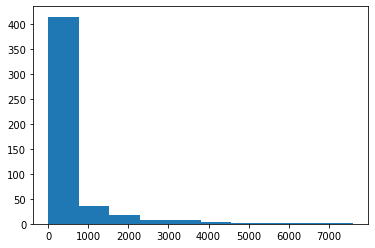

In [103]:
plt.hist(df['IBP QTY'])
plt.show()

Из гистограммы видно, что большая часть SKU продается чуть менее 600 шт. Проверим то же самое на боксполоте:

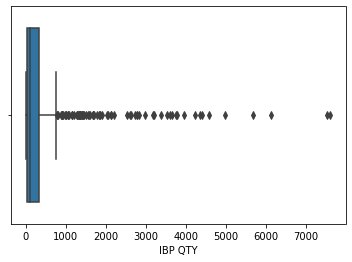

In [104]:
sns.boxplot(df['IBP QTY'])
plt.show()

Действительно, SKU с продажами > 800 шт находятся за пределами 3-го квантиля.
Проверим среднее по выборке, стандартное отклонение и дисперсию

In [106]:
mean = np.mean(df['IBP QTY'])
std = np.std(df['IBP QTY'], ddof=1)
var = np.var(df['IBP QTY'], ddof=1)

mean, std, var

(470.9695740365112, 982.446478137976, 965201.0824057125)

Итак, чтобы построить модель регрессии, нужно привести категориальную переменную Sales Line/Subtheme Manual 
к количественной - сделаю с помощью one hot encoder

In [108]:
df = df.reset_index().set_index('Article/Placeholder NO')
df.head()

,index,Sales Line/Subtheme Manual,"RRP, RUB",IBP NoS,IBP LC,IBP QTY
Article/Placeholder NO,,,,,,
B22705,0,ACTION SPORTS,5690.0,43,14.57,160.0
B22706,1,ACTION SPORTS,5349.0,43,14.57,235.0
B22707,2,ACTION SPORTS,5349.0,10,14.57,46.0
B27793,3,ACTION SPORTS,5690.0,16,13.14,106.0
B27795,4,ACTION SPORTS,5690.0,4,13.14,39.0


In [109]:
df['index'] = df['index'].to_string

In [110]:
X = df.drop(columns='index').select_dtypes(include=[object])

In [111]:
X = X.replace(0, 'OTHER', inplace=False)
X['Sales Line/Subtheme Manual'].unique()

array(['ACTION SPORTS', 'WINTER', 'STAN SMITH', 'NMD', 'SUPERSTAR',
       'TERRACE', 'ZX', 'EQT', 'PROPHERE', 'CONTINENTAL 80', 'OTHER',
       'POD', 'RUNNING', 'FASHION', 'MESH', 'SAMBA', 'Stan Smith',
       'HAVEN/ZX', 'FLIP_FLOPS', 'STREETBALL', 'NITE JOGGER/ZX 2K BOOST',
       'OZWEEGO', 'SUPERCOURT', 'NIZZA'], dtype=object)

In [112]:
X = X.reset_index()

In [113]:
le = preprocessing.LabelEncoder()
X['Sales Line/Subtheme Manual_Cat'] = le.fit_transform(X['Sales Line/Subtheme Manual'])

In [114]:
X_2 = X.set_index('Article/Placeholder NO')

In [115]:
enc = preprocessing.OneHotEncoder()
onehotlabels = pd.DataFrame(enc.fit_transform(X[['Sales Line/Subtheme Manual_Cat']]).toarray())

In [116]:
data_hot_encoded = X.join(onehotlabels)
data_hot_encoded

,Article/Placeholder NO,Sales Line/Subtheme Manual,Sales Line/Subtheme Manual_Cat,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
0,B22705,ACTION SPORTS,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B22706,ACTION SPORTS,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B22707,ACTION SPORTS,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,B27793,ACTION SPORTS,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,B27795,ACTION SPORTS,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,G27707,CONTINENTAL 80,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489,M20324,STAN SMITH,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,M20325,STAN SMITH,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,M20327,STAN SMITH,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
data_hot_encoded2 = data_hot_encoded.drop(columns=['Sales Line/Subtheme Manual', 'Sales Line/Subtheme Manual_Cat']).set_index('Article/Placeholder NO')
data_hot_encoded2.head(20)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Article/Placeholder NO,,,,,,,,,,,,,,,,,,,,,
B22705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B22706,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B22707,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B27793,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B27795,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B27796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B44945,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BY4027,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B28054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [118]:
col_names = list(le.classes_)

In [119]:
data_hot_encoded2 = data_hot_encoded2.rename(columns=dict(zip(data_hot_encoded2,col_names)))

In [120]:
data_hot_encoded2 = data_hot_encoded2.reset_index()

In [121]:
train_df = df.join(data_hot_encoded2.set_index('Article/Placeholder NO'), on='Article/Placeholder NO')

In [122]:
train_df = train_df.drop(columns=['index', 'Sales Line/Subtheme Manual'])

In [123]:
train_df['IBP NoS'].replace(np.nan, train_df['IBP NoS'].mean(), inplace=True)
train_df['IBP QTY'].replace(np.nan, train_df['IBP QTY'].mean(), inplace=True)
train_df['IBP LC'].replace(np.nan, train_df['IBP LC'].mean(), inplace=True)
train_df['RRP, RUB'].replace(np.nan, train_df['RRP, RUB'].mean(), inplace=True)

Ура, мой кривой код сработал и я наконец привел все к отдельным векторам

In [124]:
train_df

,"RRP, RUB",IBP NoS,IBP LC,IBP QTY,ACTION SPORTS,CONTINENTAL 80,EQT,FASHION,FLIP_FLOPS,HAVEN/ZX,...,RUNNING,SAMBA,STAN SMITH,STREETBALL,SUPERCOURT,SUPERSTAR,Stan Smith,TERRACE,WINTER,ZX
Article/Placeholder NO,,,,,,,,,,,,,,,,,,,,,
B22705,5690.0,43,14.57,160.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B22706,5349.0,43,14.57,235.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B22707,5349.0,10,14.57,46.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B27793,5690.0,16,13.14,106.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B27795,5690.0,4,13.14,39.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M20325,6999.0,221,52.29,3168.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M20327,6999.0,221,52.29,4570.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M20327,6999.0,221,52.29,4570.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


С помощью skleatn построю модель линейной регрессии:

In [125]:
feature_names = list(train_df.drop(columns='IBP QTY'))
target_name = ['IBP QTY']

In [126]:
X = train_df[feature_names]
y = train_df[target_name]

In [127]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [128]:
X_train.head()

,"RRP, RUB",IBP NoS,IBP LC,ACTION SPORTS,CONTINENTAL 80,EQT,FASHION,FLIP_FLOPS,HAVEN/ZX,MESH,...,RUNNING,SAMBA,STAN SMITH,STREETBALL,SUPERCOURT,SUPERSTAR,Stan Smith,TERRACE,WINTER,ZX
Article/Placeholder NO,,,,,,,,,,,,,,,,,,,,,
BB7041,15990.0,2,12.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B37453,8990.0,33,31.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EE5304,10999.0,1,33.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BB5478,6999.0,202,52.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
B41967,8990.0,10,9.14,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [136]:
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_val)

print(f'R2 Score для тренировочного датасета: {r2(y_train, y_train_preds):.2f}')
print(f'R2 Score для валидационного датасета: {r2(y_val, y_test_preds):.2f}')

R2 Score для тренировочного датасета: 0.78
R2 Score для валидационного датасета: 0.75


In [138]:
# Как видно линейная регрессеия показывает низкие результаты, попробую random forest:
rf_model = RandomForestRegressor(random_state=42, n_estimators = 200)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [140]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_val)

print(f'R2 Score для тренировочного датасета: {r2(y_train, y_train_preds):.2f}')
print(f'R2 Score для валидационного датасета: {r2(y_val, y_test_preds):.2f}')

R2 Score для тренировочного датасета: 0.97
R2 Score для валидационного датасета: 0.81


Стало чуть лучше, но все равно не сахар

In [143]:
# Посмотрим среднюю ошибку модели:
errors = abs(y_test_preds - y_val['IBP QTY'])
print('Mean Absolute Error:', round(np.mean(errors), 2), 'pcs.')

Mean Absolute Error: 257.66 pcs.


То есть, при средних продажах в 470 шт., модель выдает прогноз со средней ошибкой 257 шт. - это провал, конечно.
Посмотрим на важность переменных:

In [144]:
importances = list(rf_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: IBP NoS                                  Importance: 0.78
Variable: RRP, RUB                                 Importance: 0.1
Variable: IBP LC                                   Importance: 0.06
Variable: HAVEN/ZX                                 Importance: 0.02
Variable: STAN SMITH                               Importance: 0.02
Variable: OZWEEGO                                  Importance: 0.01
Variable: TERRACE                                  Importance: 0.01
Variable: ACTION SPORTS                            Importance: 0.0
Variable: CONTINENTAL 80                           Importance: 0.0
Variable: EQT                                      Importance: 0.0
Variable: FASHION                                  Importance: 0.0
Variable: FLIP_FLOPS                               Importance: 0.0
Variable: MESH                                     Importance: 0.0
Variable: NITE JOGGER/ZX 2K BOOST                  Importance: 0.0
Variable: NIZZA                                    Impor

То есть, среди всех признаков, кол-во магазинов идет с весом 0.78, цена 0.1, а остальные почти ничего не весят - боль.

Ок, чтобы проверить, действительно незначительно отличие самых важных категории товара, проыерю первые две:
HAVEN/ZX и STAN SMITH, так как они самые значимые

In [155]:
y1 = np.array(df.loc[df['Sales Line/Subtheme Manual'] == 'HAVEN/ZX']['IBP QTY'], dtype='int32')
y2 = np.array(df.loc[df['Sales Line/Subtheme Manual'] == 'STAN SMITH']['IBP QTY'], dtype='int32')

n1 = y1.shape[0]
n2 = y2.shape[0]

y1.mean(), y2.mean()

(5636.0, 1166.909090909091)

In [154]:
y = np.concatenate([y1, y2])
y_mean = y.mean()

y_mean

1703.2

Найдём значения $SS_b$ и $SS_w$:

In [158]:
SS_b = n1 * (y1.mean() - y_mean) ** 2 + n2 * (y2.mean() - y_mean) ** 2
SS_w = ((y1 - y1.mean()) ** 2).sum() + ((y2 - y2.mean()) ** 2).sum()

SS_b, SS_w

(52728122.18181819, 70962133.81818183)

Запишем оценки дисперсий:

In [ ]:
k = 2
n = n1 + n2

k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2

sigma2_b, sigma2_w

Итак, значение статистики $F$:

In [160]:
F = sigma2_b / sigma2_w
F

17.090055568073826

Зафиксируем уровень значимости $\alpha = 0.05$. Для него найдём нужный нам квантиль:

In [162]:
from scipy import stats

In [163]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

4.279344309144648

Итак, наша критическая область имеет вид:
$$\Omega_\alpha = \left( 4.27, \infty \right)$$

(-0.09652113945530356, 0.5)

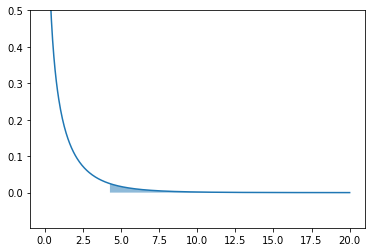

In [169]:
ox = np.linspace(0, 20, 500)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 20, 100)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.fill_between(ox_right, oy_right, alpha=0.5)
plt.ylim(top=0.5)

Значение статистики попало в критическую область, поэтому заключаем, что отличие средних продаж между двумя категориям действительно является статистически значимым.

# Выводы:

Для текущего датасета недостаточно просто построить модели линейной регресси или случайного леса - среднаяя ошибка все равно очень большая.
Нужно либо очистить датасет от выбросов в целевой переменной, либо добавить новые фичи -  материал, средняя скидка, участие в промо акциях или расширить выборку.
Касательно категорий товаров - действительно, с точки зрения ассртимента, между ними есть значимая разница на примере Haven/ZX и Stan Smith н - дальше можно исследовать оставшиеся, найти наименее зависимые и попытаться их объединить, сократить их кол-во.